In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk import ngrams
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # acf和pacf展示库
from statsmodels.tsa.stattools import adfuller  # adf检验库
from statsmodels.stats.diagnostic import acorr_ljungbox  # 随机性检验库
from statsmodels.tsa.arima_model import ARMA  # ARMA库
from statsmodels.tsa.seasonal import seasonal_decompose


from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


## 导入数据+数据预处理(问题1)
    1、将评论时期转化为时间序列
    2、将评论内容为"No complaints"、"No comment"的内容（即默认好评），替换为"good"
    3、评论星数归一化、查看数据分布。
   
    4、将vine、veritifed_purchase转化为0、1的数值型数据
    5、对整个数据集，新增一列销量（即reviews的数量）
    6、查看数值型数据的相关性（热力图）
    7、对数值型数据进行关联分析

In [2]:
df=pd.read_table("hair_dryer.tsv")
df['review_date']=pd.to_datetime(df['review_date'])
index=df[(df['review_body']=="No complaints") | (df['review_body']=='no comment')].index
df.loc[index,['review_body']]="good"
df=df.sort_values('review_date')

df.loc[df['vine']=="N","vine"]=0
df.loc[df['vine']=="Y","vine"]=1
df.loc[df['verified_purchase']=="Y","verified_purchase"]=1
df.loc[df['verified_purchase']=="N","verified_purchase"]=0

df['reviews']=0
unique_id=df['product_id'].drop_duplicates().tolist()
dicts=dict(zip(unique_id,df['reviews'].tolist()))
for i in range(len(df)):
    pid=df.iloc[i,3]#product_id
    vf=df.iloc[i,11]#verified_purchase
    if vf==1:
        dicts[pid]+=1
        df.iloc[i,-1]=dicts[pid]
    else:
        df.iloc[i,-1]=dicts[pid]

df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,reviews
11469,US,43740490,R2XM83JYE2KDE2,B00005O0MZ,694290590,conair corp pers care 146np conair ionic condi...,Beauty,3,320,332,0,1,"Some pluses, some minuses",This is my only experience with an ionic hair ...,2002-03-02,1
11468,US,38947355,R3JMGN42OJCL97,B00005O0MZ,694290590,conair corp pers care 146np conair ionic condi...,Beauty,5,78,87,0,0,Excellent for fine/limp hair,This hairdryer far exceeded my expection for<B...,2002-04-20,1
11467,US,37733836,R3GO6L5PWBS0IW,B00005O0MZ,694290590,conair corp pers care 146np conair ionic condi...,Beauty,5,4,4,0,1,The best dryer!!!,"I love this dryer not only is it QUIET, it rea...",2002-07-13,2
11466,US,43977044,R2JQPUYU65C4QD,B00005O0MZ,694290590,conair corp pers care 146np conair ionic condi...,Beauty,1,26,32,0,0,Disappointment with dryer,I purchased it because it was supposed to be q...,2002-08-13,2
11465,US,35599734,R2O50YNP83CG34,B000065DJY,919751065,revlon 1875w volumizing hair dryer,Beauty,5,14,18,0,0,great hair!,"I just purchased this dryer, and I really like...",2002-08-21,0


In [3]:
df=df.drop(['customer_id','marketplace','product_category','product_title','product_category','review_id'],axis=1)

## 协方差

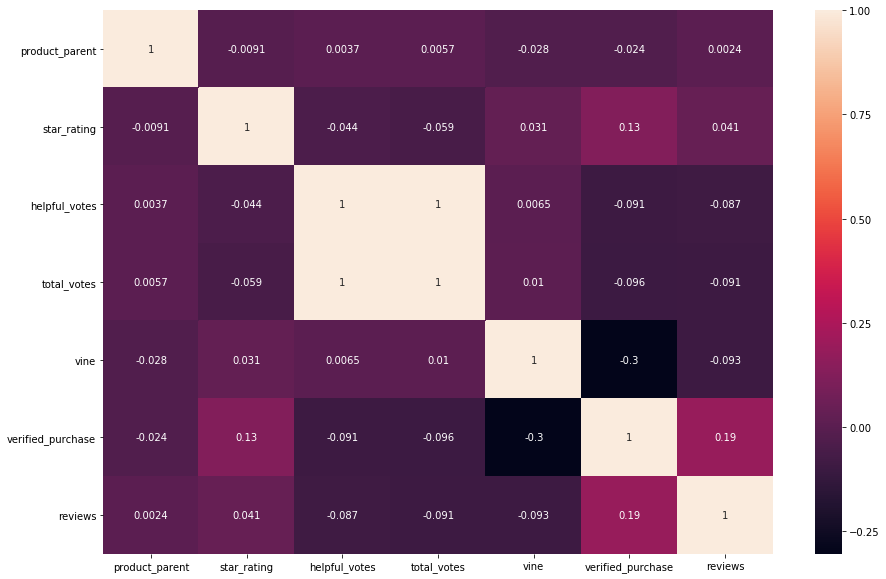

In [4]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.savefig("heatmap.jpg")

* 从热力图可以看到，helpful_votes与total_votes之间有着很强的关联，计算helpful/total
* 观察star_rating列，发现可能与其有相关性的特征是vine与veritified_purchase

## 关联分析
  * 独热编码前将helpful_votes、reviews转换为离散型变量（具体离散值根据数据分布情况来定）
  * 求出helpful_rate(有用评论占总体的比例) 0-0.5为1，大于0.5为2
  * 对数据进行独热编码（主要是星级数据和helpful_votes）
  * 算法Apriori关联分析(设置的最小置信度为60%)

(0, 600)

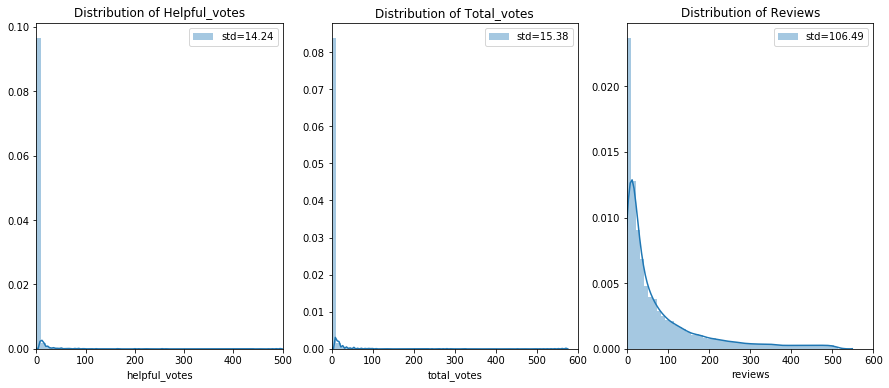

In [5]:
plt.figure(figsize=(15,6))

plt.subplot(131)
plt.title("Distribution of Helpful_votes")
label="std={:.2f}".format(df['helpful_votes'].std())
sns.distplot(df['helpful_votes'],label=label)
plt.xlim(0,500)
plt.legend()

plt.subplot(132)
plt.title("Distribution of Total_votes")
label="std={:.2f}".format(df['total_votes'].std())
sns.distplot(df['total_votes'],label=label)
plt.legend()
plt.xlim(0,600)

plt.subplot(133)
plt.title("Distribution of Reviews")
label="std={:.2f}".format(df['reviews'].std())
sns.distplot(df['reviews'],label=label)
plt.legend()
plt.xlim(0,600)

### 构建新的一列特征（helpful_rating）

In [6]:
helpful_index=df.loc[df['helpful_votes']>0].index
df['helpful_rating']=0
df.loc[helpful_index,'helpful_rating']=df.loc[helpful_index]['helpful_votes']/df.loc[helpful_index]['total_votes']

### 将连续型变量转化为离散型

In [7]:
df['real_helpful']=0
df['reviews_dis']=0
for i in range(100,600,100):
    if i<400:
        index=df[(df['reviews']>i-100) & (df['reviews']<i)].index
        df.loc[index,'reviews_dis']=i/100
    else:
        index=df[(df['reviews']>i-100)].index
        df.loc[index,'reviews_dis']=i/100

index=df[df['helpful_rating']>0.8].index
df.loc[index,'real_helpful']=1
index=df[(df['helpful_rating']<0.8) & (df['helpful_rating']>0)].index
df.loc[index,'real_helpful']=-1

## 根据置信度排序

In [8]:

df1=df[['star_rating','vine','verified_purchase','real_helpful','reviews_dis']].astype('category')
df1=pd.get_dummies(df1)
freq = apriori(df1, min_support=0.05, use_colnames=True)

#计算关联规则
result = association_rules(freq, metric="confidence", min_threshold=0.85)
result=result.drop(result[result['confidence']==1].index,axis=0)
result=result.sort_values("confidence",ascending=False)
#去掉无用的后置关联
result=result.drop(result[result["consequents"]==frozenset({'vine_0'})].index,axis=0)
# result=result.drop(result[result["consequents"]==frozenset({'votes_dis_0.0'})].index,axis=0)
# result=result.drop(result[result["consequents"]==frozenset({'vine_0', 'votes_dis_0.0'})].index,axis=0)

result[['antecedents', 'consequents','confidence','lift']].head(10)

,antecedents,consequents,confidence,lift
90,"(star_rating_5, vine_0, reviews_dis_2.0)",(verified_purchase_1),0.953210,1.114394
91,"(star_rating_5, reviews_dis_2.0)","(verified_purchase_1, vine_0)",0.953210,1.114508
46,"(star_rating_5, reviews_dis_2.0)",(verified_purchase_1),0.953210,1.114394
98,"(real_helpful_0, star_rating_5, reviews_dis_2.0)",(verified_purchase_1),0.953165,1.114341
117,"(real_helpful_0, star_rating_5, vine_0, review...",(verified_purchase_1),0.953165,1.114341
120,"(real_helpful_0, star_rating_5, reviews_dis_2.0)","(verified_purchase_1, vine_0)",0.953165,1.114454
70,"(real_helpful_0, reviews_dis_2.0)",(verified_purchase_1),0.952978,1.114123
107,"(real_helpful_0, reviews_dis_2.0, vine_0)",(verified_purchase_1),0.952978,1.114123
108,"(real_helpful_0, reviews_dis_2.0)","(verified_purchase_1, vine_0)",0.952978,1.114236
60,(reviews_dis_2.0),"(verified_purchase_1, vine_0)",0.949196,1.109814


## 根据提升度排序

In [9]:
result=result.sort_values("lift",ascending=False)
result[['antecedents', 'consequents','confidence','lift']].head(5)

,antecedents,consequents,confidence,lift
102,"(verified_purchase_1, real_helpful_-1)","(reviews_dis_1.0, vine_0)",0.908546,1.297761
101,"(verified_purchase_1, vine_0, real_helpful_-1)",(reviews_dis_1.0),0.908546,1.279281
68,"(verified_purchase_1, real_helpful_-1)",(reviews_dis_1.0),0.908546,1.279281
95,"(star_rating_5, reviews_dis_2.0)","(real_helpful_0, vine_0)",0.859630,1.271268
119,"(verified_purchase_1, star_rating_5, reviews_d...","(real_helpful_0, vine_0)",0.859589,1.271208


## 结论：最能影响顾客购买的是产品的星级、其次是销量

## Problem_a
* **选取星级与评论两列数据、通过情感分析新增"积极"、"中立"、"消极"、"得分"四列数据**    

      1、对于每条评论，进行情感分析，给出相应得分。（积极：中立：消极=1:0：-1）
      2、将星级归一化，与评论得分进行加权。（星级：评论=7:3）

In [10]:
pos=[]#积极程度
neu=[]#中立
neg=[]#消极
cum=[]#复杂度
sid = SentimentIntensityAnalyzer()
for i in df['review_body']:
    ss = sid.polarity_scores(i)
    pos.append(ss['pos'])
    neu.append(ss['neu'])
    neg.append(ss['neg'])
    cum.append(ss['compound'])

In [11]:
df['positive']=pos
df['neutral']=neu
df['negative']=neg
df['cum']=cum
p_a=df[['star_rating','positive','neutral','negative']]#问题a的数据
p_a['sense_score']=p_a['star_rating']/5*0.7+(p_a['positive']-p_a['negative'])*0.3
df['sense_score']=p_a['sense_score']
p_a

,star_rating,positive,neutral,negative,sense_score
11469,3,0.144,0.839,0.017,0.4581
11468,5,0.091,0.886,0.023,0.7204
11467,5,0.235,0.715,0.050,0.7555
11466,1,0.048,0.919,0.033,0.1445
11465,5,0.159,0.841,0.000,0.7477
...,...,...,...,...,...
4,4,0.438,0.562,0.000,0.6914
3,5,0.000,1.000,0.000,0.7000
2,5,0.692,0.308,0.000,0.9076
1,4,0.223,0.777,0.000,0.6269


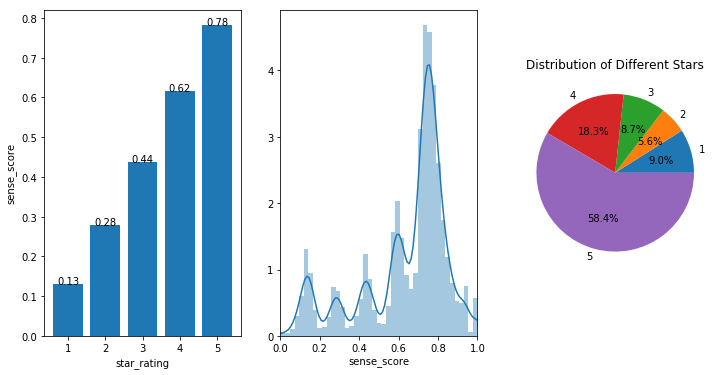

In [12]:
plt.figure(figsize=(12,6))

stars1=p_a.groupby('star_rating').agg('mean')#The mean score of different star rating
stars2=p_a.groupby('star_rating').agg('count')#The number of different star rating

plt.subplot(131)
plt.bar(stars1.index,stars1['sense_score'])
for x, y in zip(stars1.index, stars1['sense_score']):
    plt.text(x, y ,"%.2f"%y,ha="center")
plt.xlabel('star_rating')
plt.ylabel('sense_score')
plt.subplot(132)
sns.distplot(p_a['sense_score'])
plt.xlim(0,1)

plt.subplot(133)
plt.pie(stars2['sense_score'],labels=stars2.index,autopct='%1.1f%%')
plt.title('Distribution of Different Stars')
plt.show()

## Problem b
* **在a问的基础上新增一列评论时间**
      
      1、以年为单位进行分析，求出每年的总销量 和 商品的平均得分

## B0、（数据探索EDA）
 * 1、以年为单位分析、可视化每年的平均得分（基于a的评判标准）、每年的得分总和（折线图2）
 * 2、以季度为单位分析、发现第一季度总是相对前一季度有所增长

[0.002, 0.0025, 0.002, 0.005, 0.01775, 0.0455, 0.05775, 0.07525, 0.145, 0.15825, 0.2285, 0.5355, 0.799, 0.7825]
[0.5975624999999999, 0.66055, 0.4694, 0.5935800000000001, 0.4646478873239437, 0.5892005494505494, 0.561612121212121, 0.591191362126246, 0.5735558620689649, 0.5747014218009472, 0.5953969365426689, 0.627783940242763, 0.6506840425531931, 0.674756038338658]


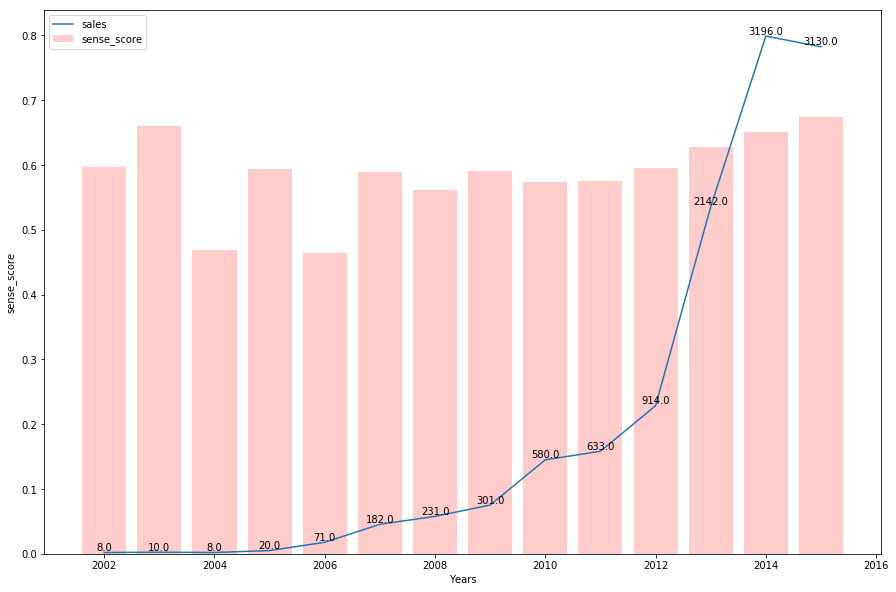

In [210]:
p_b=pd.concat([p_a,df[['review_date','real_helpful','vine']]],axis=1)
p_b=p_b.sort_values('review_date')
p_b=p_b.set_index('review_date')
p_b[p_b.index<'2003']
year_score=[]#每年的评论得分的均值
year_sales=[]#每年的商品总销量
years=np.arange(2002,2016)
for i in range(2003,2017):
    each_year=p_b[(p_b.index<str(i)) & (p_b.index>str(i-1))]

    year_score.append(each_year['sense_score'].mean())
    year_sales.append(len(each_year)/4000)
print(year_sales)
print(year_score)
plt.figure(figsize=(15,10))

plt.bar(years,year_score,color='red',alpha=0.2,label="sense_score")
plt.legend()
for x, y in zip(years, year_sales):
    plt.text(x, y , str(y*4000), ha='center', va='bottom', fontsize=10, rotation=0)
plt.plot(np.arange(2002,2016),year_sales,label="sales")
plt.xlabel("Years")
plt.ylabel("sense_score")
plt.legend()

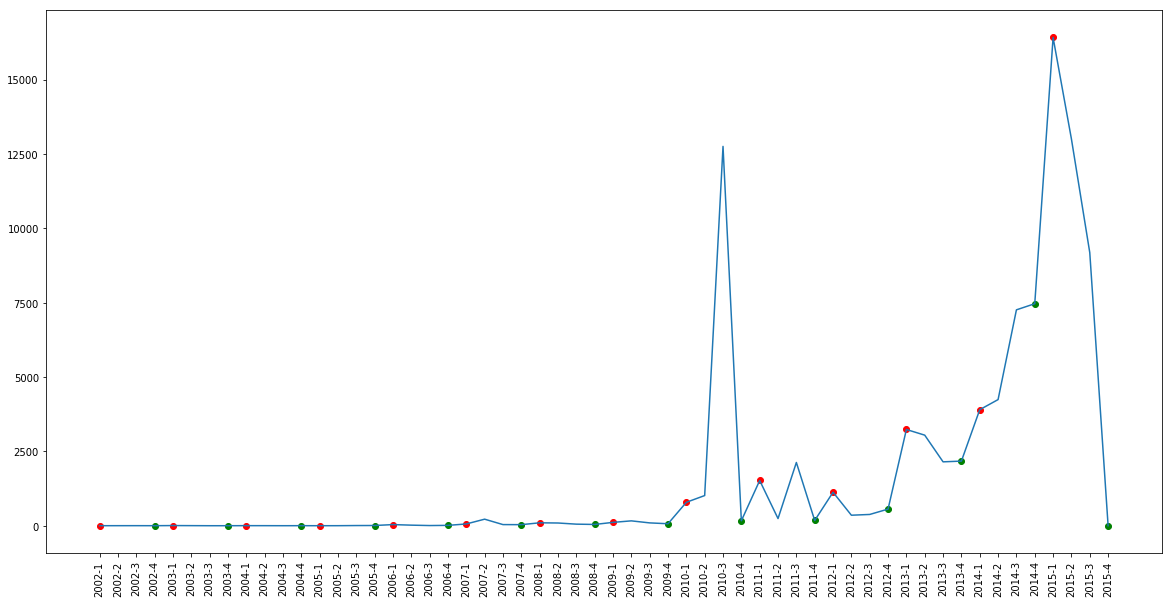

In [212]:

season_name=[]
season_score=[]

for i in range(2002,2016):
    index1=p_b[(p_b.index>str(i)+"-01")& (p_b.index<str(i)+'-04')].index
    season_score.append(p_b.loc[index1,'sense_score'].sum())
    season_name.append(str(i)+"-1")

    index2=p_b[(p_b.index>str(i)+"-03")& (p_b.index<str(i)+'-07')].index
    season_score.append(p_b.loc[index2,'sense_score'].sum())
    season_name.append(str(i)+"-2")
    
    index3=p_b[(p_b.index>str(i)+"-06")& (p_b.index<str(i)+'-10')].index
    season_score.append(p_b.loc[index3,'sense_score'].sum())
    season_name.append(str(i)+"-3")
    
    index4=p_b[(p_b.index>str(i)+"-09")& (p_b.index<=str(i)+'-12')].index
    season_score.append(p_b.loc[index4,'sense_score'].sum())
    season_name.append(str(i)+"-4")
season=pd.DataFrame({'season':season_name,'score':season_score})
plt.figure(figsize=(20,10))
plt.plot(season_name,season_score)
season1=season[season['season'].str.contains('-1')].index
plt.scatter(season.loc[season1,'season'],season.loc[season1,'score'],color='red')

season2=season[season['season'].str.contains('-4')].index
plt.scatter(season.loc[season2,'season'],season.loc[season2,'score'],color='green')

plt.xticks(rotation=90)
plt.show()

### =============================================================================================
* 2、将数据以月为单位进行聚合，求平均值
* 3、构建一列新的特征h_sense_score，
       当评论有点赞，且该评论为有用评论，则h_sense_score=(1+20%)*sense_score
       当评论有点赞，且该评论为无用评论，则h_sense_score=(1-20%)*sense_score
       当评论无点赞，则h_sense_score=sense_score

<Figure size 1800x864 with 0 Axes>

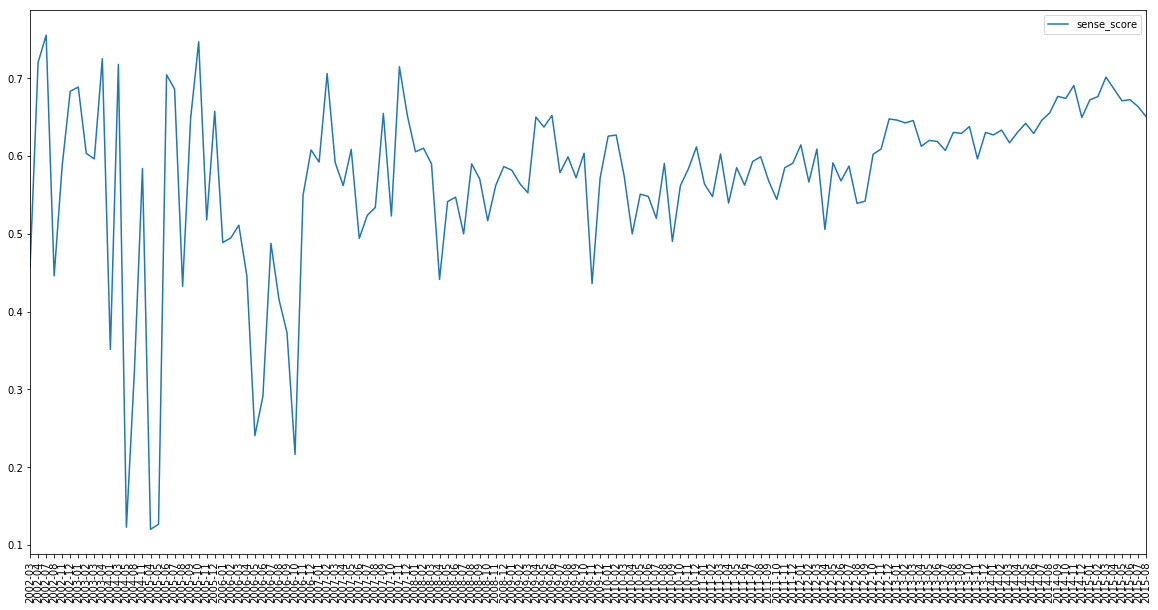

In [14]:

p_b['DATE'] = [datetime.strftime(x,'%Y-%m') for x in p_b.index]
p_b=p_b.set_index('DATE')
p_b_star=p_b.groupby([p_b.index,p_b['star_rating']]).agg({'star_rating':'count'})#求各个star的count
p_b_star=p_b_star.reset_index(level=0)

p_b=p_b.groupby(p_b.index).agg('mean')

#对helpful相关进行打分
h_sense_score=[]
for index,row in p_b.iterrows():
    if row['real_helpful']==1:
        if row['sense_score']>0.5:
            h_sense_score.append(row['sense_score']*1.2)
        else:
            h_sense_score.append(row['sense_score']*0.8)
    else:
        h_sense_score.append(row['sense_score'])
p_b['h_sense_score']=h_sense_score
diff_score=p_b['h_sense_score']-p_b['sense_score']
diff_index=diff_score[diff_score<0].index

plt.figure(figsize=(25,12))

plt.figure(figsize=(20,10))
# plt.plot(p_b_star['DATE'],[0]*len(p_b_star),linestyle='')
# for i in range(1,6):
#     s=p_b_star[p_b_star.index==i]
#     plt.plot(s['DATE'],s['star_rating'],label=i)
plt.plot(p_b.index,p_b['sense_score'],label='sense_score')


# plt.plot(p_b.index,p_b['sense_score'],label='sense_score')
# plt.plot(p_b.index,p_b['h_sense_score'],label='sense_score2')
# plt.scatter(diff_index,p_b.loc[diff_index,'sense_score'],label='sense_score2',color='r')
# plt.plot(p_b.index,p_b['real_helpful'],label='real_helpful')
# plt.plot(p_b.index,p_b['vine'],label='number of vines')
plt.xticks(rotation=90)
plt.xlim('2002-03','2015-08')
# plt.ylim(0,350)
plt.legend()
plt.show()

## B1、构建时间序列分析相关的函数
 

In [16]:
# 移动平均图
def draw_trend(timeSeries, size):
 
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    rol_std= timeSeries.rolling(window=size).std()
    
    plt.figure(figsize=(18,8))
    plt.plot(timeSeries,color='blue', label='Original')
    plt.plot(rol_mean,color='red', label='Rolling Mean')
    plt.plot(rol_std,color='black', label='Rolling Std')
    plt.xticks(rotation=90)
    plt.xlim('2002-03','2015-08')
    plt.legend(loc='best')
    plt.show()


def draw_ts(timeSeries):
    f = plt.figure(facecolor='white',figsize=(12,10))
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
  
    f = plt.figure(facecolor='white',figsize=(10,10))
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

## B1、查看原始数据

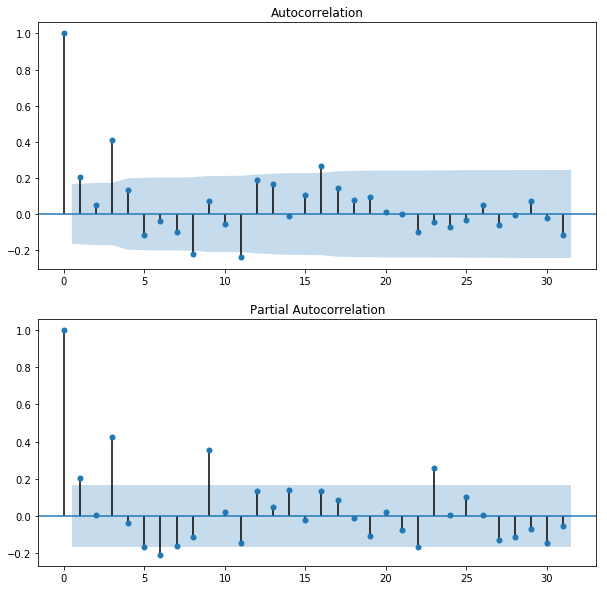

<Figure size 864x720 with 0 Axes>

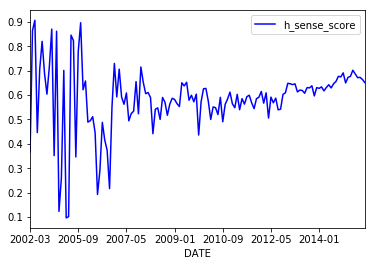

Test Statistic                  -3.318860
p-value                          0.014056
#Lags Used                       8.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [17]:
ts_data=p_b[['h_sense_score']]
draw_acf_pacf(ts_data)
draw_ts(ts_data)
testStationarity(ts_data)

### 上述表格的看法：
   * 如果Test Ststistic<Critical Value（s）  s表示的是括号中的值，即说明该时间序列在(1-s)的置信度区间内是稳定的
   * p_value越接近0说明这个时间序列越稳定

## B2、数据平稳性处理
  ###  1、取对数
  ###  2、平滑处理(因为是月数据，此时设置滑动窗口12，减小年的影响趋势)


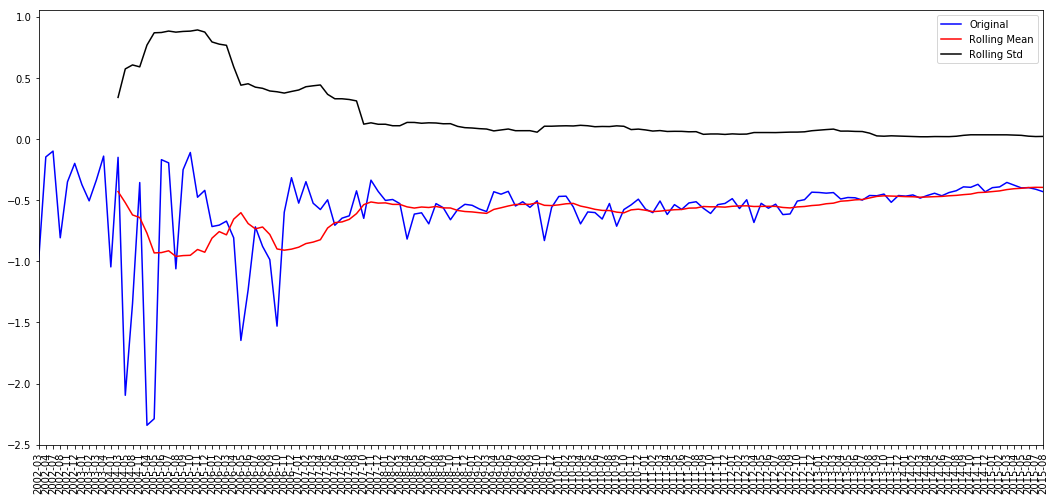

In [18]:
ts_log = np.log(ts_data)
# draw_ts(ts_log.diff(12))
draw_trend(ts_log, 12)

## B3、查看时间序列分解分解

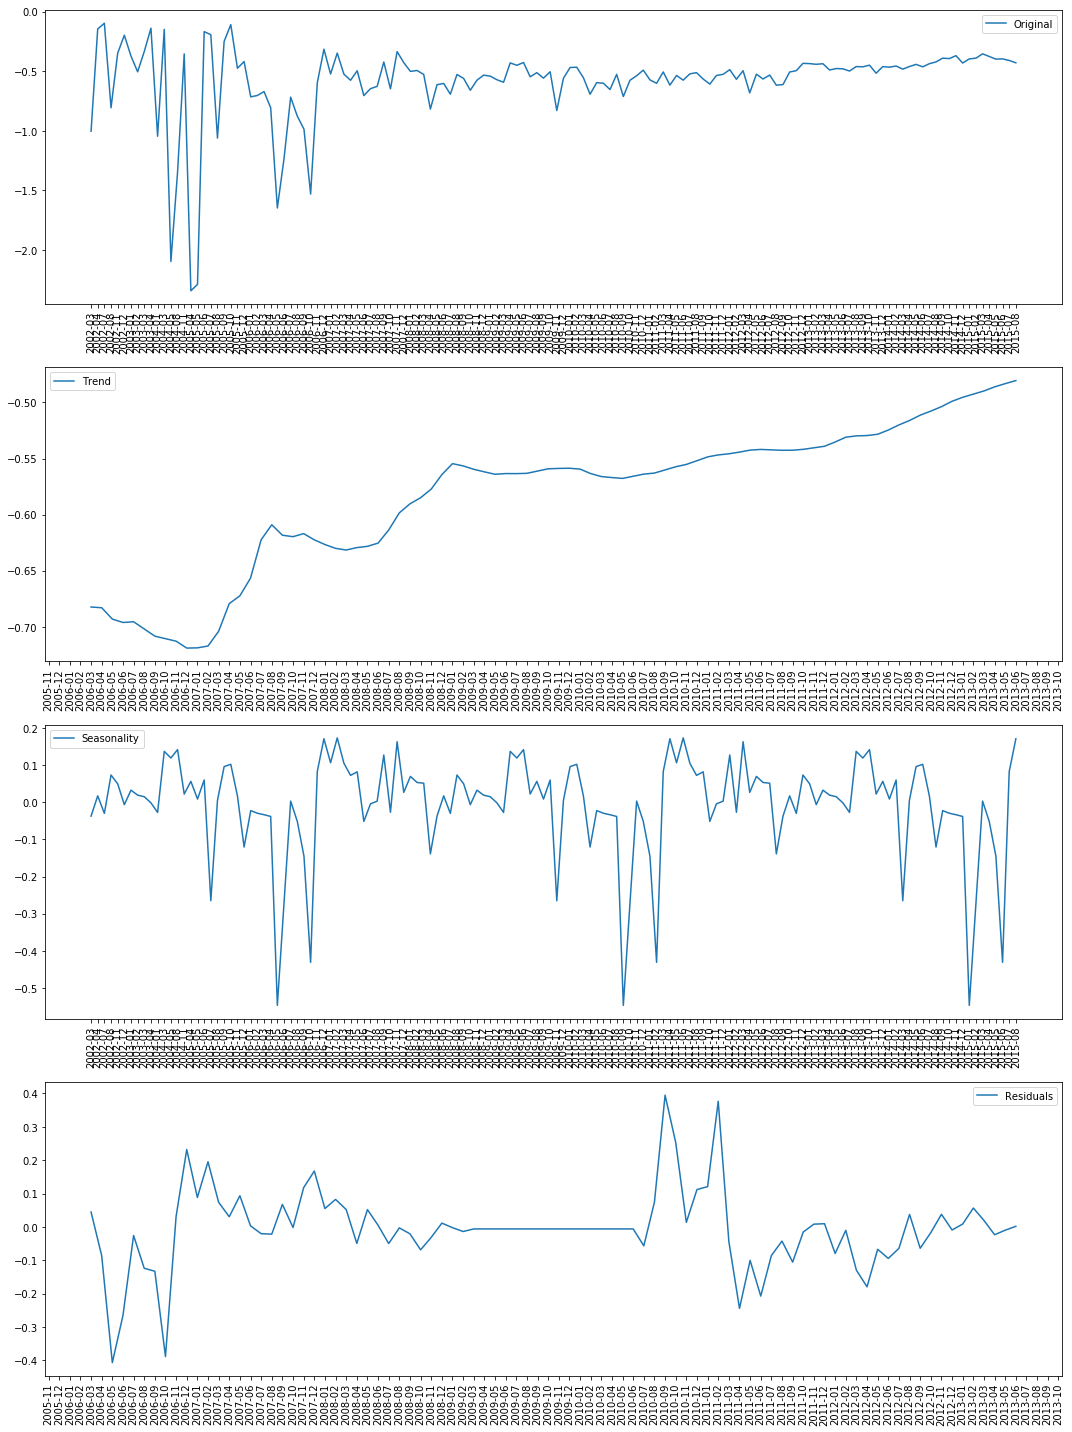

In [19]:
ts_log.dropna(inplace=True)
# ts_log=ts_log.set_index('DATE')
decomposition = seasonal_decompose(ts_log,freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15,20))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.xticks(rotation=90)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation=90)

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.xticks(rotation=90)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

* 以上图中趋势可以看作信誉变化的趋势，周期我认为可以理解为产品的使用年限

### B4、差分运算，进一步降低波动性

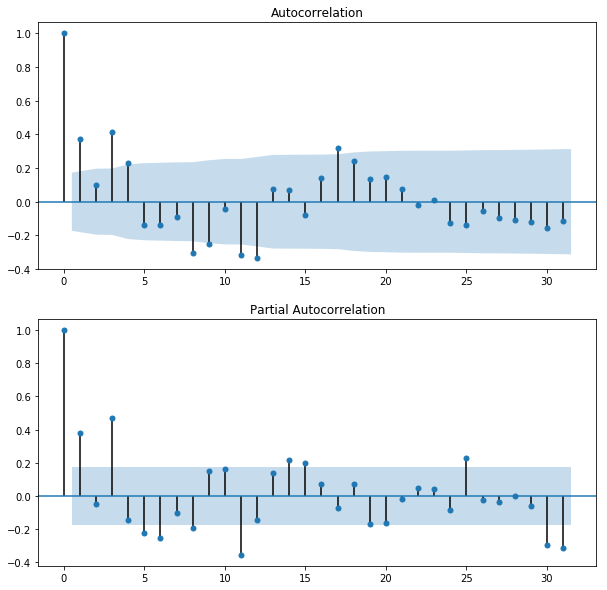

Test Statistic                  -3.667490
p-value                          0.004594
#Lags Used                      13.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64

In [20]:
ts_log = np.log(ts_data)
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)

draw_acf_pacf(ts_diff_1)
testStationarity(ts_diff_1)

## B5、训练模型，模型评估（评估参数：均方误差RMSE）

In [21]:

def ts_model(ts_data,ts_colname,save_name):
    '''
    ts_data:The time series data
    ts_colname:colname of original dataset
    save_name:output picture 
    '''
    ts_log = np.log(ts_data)
    rol_mean = ts_log.rolling(window=12).mean()
    rol_mean.dropna(inplace=True)
    ts_diff_1 = rol_mean.diff(1)
    ts_diff_1.dropna(inplace=True)
    testStationarity(ts_diff_1)
    def rmse(predictions, targets): 
        predictions=np.array(predictions)
        targets=np.array(targets)
        return np.sqrt(((predictions - targets) ** 2).mean()) 

    model = ARIMA(ts_diff_1, order=(5,1,6)) 
    result_arima = model.fit( disp=-1, method='css')

    predict_ts = result_arima.predict()
    print(len(predict_ts))
    # 一阶差分还原
    diff_shift_ts = ts_diff_1.shift(1)
    diff_shift_ts.dropna(inplace=True)
    diff_shift_ts = pd.Series(diff_shift_ts[ts_colname].values, index=diff_shift_ts.index)
    diff_recover_1 = predict_ts.add(diff_shift_ts)
    # 再次一阶差分还原
    rol_shift_ts = rol_mean.shift(1)
    rol_shift_ts = pd.Series(rol_shift_ts[ts_colname].values, index=rol_shift_ts.index)
    diff_recover = diff_recover_1.add(rol_shift_ts)
    # 移动平均还原
    rol_sum = ts_log.rolling(window=11).sum()
    rol_sum.dropna(inplace=True)
    rol_sum = pd.Series(rol_sum [ts_colname].values, index=rol_sum .index)
    rol_recover = (diff_recover*12).sub(rol_sum.shift(1))
    # 对数还原
    log_recover = np.exp(rol_recover)
    log_recover.dropna(inplace=True)

    log_recover.plot(color='blue', label='Predict')
    plt.plot(ts_data,color='red', label='Original')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% rmse(log_recover,ts_data))
    plt.savefig(save_name)
    plt.show()

122


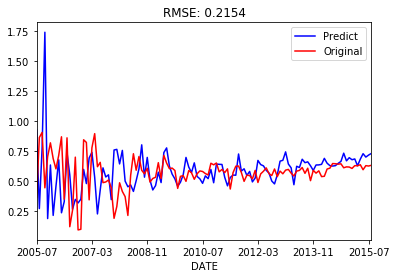

In [26]:
ts_model(p_b[['h_sense_score']],'h_sense_score','ts_2.jpg')

# Problem_c
  * 首先选取real_helpful==1（在之前有定义，helpful_rating>0.5的评论）的评论，这就是我们所要分析的主要数据
  * 对评论进行分词，选取名词建立2-gram模型，找到包含产品本身评论信息的内容，将这些去掉（eg:吹风机中频繁出现的dryer、hair)
  * 去除上述关键词，选取名词建立3-gram模型，找出决定成功，失败的因素，进行词频统计
  * 通过好评、差评的结果分析，最高频率的好评差评的关键影响因素一致，说明这些是决定产品成功与否的关键

In [50]:
p_c=df[['product_id','star_rating','review_body','review_date','reviews','helpful_rating','real_helpful','sense_score']]
p_c['good_r']=[1 if i>=0.5 else 0 for i in p_c['sense_score'] ]
id_group=p_c.groupby(['product_id']).agg({'good_r':'count','reviews':'max'})
good=p_c[(p_c['real_helpful']==1) & (p_c['good_r']==1)]['review_body']
bad=p_c[(p_c['real_helpful']==1) & (p_c['good_r']==0)]['review_body']

def data_clean(review):
    if(type(review)!=list):
        review=review.tolist()
   
    review=''.join(review)
    review=re.sub(r'[^\w\s]','',review)
    review=review.replace('br','')
    print("finish clean")
    return review

def n_gram(review,n):
    reviews=word_tokenize(review)
    n_grams = ngrams(reviews, n)
  
    ngramsDist = FreqDist(n_grams)
    return ngramsDist
    
def select_tag(my_tag,pos_tags):
    '''
    Choose a specific part of speech
    '''
    result=[]
    for tag in pos_tags:
        if tag[1] in my_tag:
            result.append(tag[0])
    return result

def to_df(n_gram):
    '''
    Translate FreqDist to DataFrame
    '''
    key_word=[]
    frequence=[]
    for i in n_gram.most_common(50):
        key_word.append(i[0])
        frequence.append(i[1])

    data=pd.DataFrame({
        'key_words':key_word,
        'frequence':frequence
    })
    return data

In [51]:
pos_tags = nltk.pos_tag(word_tokenize(data_clean(good)))
good=select_tag(['NN','NNS'],pos_tags)
pos_tags = nltk.pos_tag(word_tokenize(data_clean(bad)))
bad=select_tag(['NN','NNS'],pos_tags)

finish clean
finish clean


In [52]:
good=' '.join(good)
bad=' '.join(bad)
bgram_good=to_df(n_gram(good,2))
bgram_bad=to_df(n_gram(bad,2))

## 查看2-gram的效果

In [55]:
bgram_good.head(10)

,key_words,frequence
0,"(hair, dryer)",910
1,"(dryer, hair)",310
2,"(blow, dryer)",238
3,"(hair, hair)",231
4,"(hair, dryers)",168
5,"(time, hair)",96
6,"(dryer, dryer)",83
7,"(hair, time)",81
8,"(hair, minutes)",71
9,"(heat, settings)",68


In [59]:
bgram_bad.head(10)

,key_words,frequence
0,"(hair, dryer)",254
1,"(blow, dryer)",67
2,"(dryer, hair)",66
3,"(hair, hair)",43
4,"(hair, dryers)",34
5,"(dryer, years)",34
6,"(dryer, months)",30
7,"(dryer, year)",29
8,"(dryer, dryer)",23
9,"(time, hair)",22


### 由上述结果可见，hair,dryer,blow可以去除

In [60]:
good=re.sub('hair|dryer|blow','',good)
bad=re.sub('hair|dryer|blow','',bad)


### 进行3-gram建模(以下结果取十个左右分析即可)

In [74]:
tgram_good=to_df(n_gram(good,3))
tgram_bad=to_df(n_gram(bad,3))
tgram_bad.head(20)

,key_words,frequence
0,"(speeds, heat, settings)",4
1,"(heat, settings, speeds)",3
2,"(product, warranty, product)",2
3,"(YEARS, rate, end)",2
4,"(rate, end, period)",2
5,"(end, period, replacement)",2
6,"(period, replacement, warranty)",2
7,"(replacement, warranty, Dec)",2
8,"(time, wall, mount)",2
9,"(quality, product, price)",2


In [75]:
tgram_good

,key_words,frequence
0,"(speeds, heat, settings)",7
1,"(heat, speed, settings)",7
2,"(settings, shot, button)",6
3,"(heat, settings, speed)",6
4,"(speed, heat, settings)",5
5,"(air, flow, heat)",5
6,"(speed, medium, heat)",4
7,"(folding, handle, cord)",4
8,"(heat, settings, button)",4
9,"(settings, heat, settings)",4


 CC      Coordinating conjunction 连接词
2.     CD     Cardinal number  基数词
3.     DT     Determiner  限定词（如this,that,these,those,such，不定限定词：no,some,any,each,every,enough,either,neither,all,both,half,several,many,much,(a) few,(a) little,other,another.
4.     EX     Existential there 存在句
5.     FW     Foreign word 外来词
6.     IN     Preposition or subordinating conjunction 介词或从属连词
7.     JJ     Adjective 形容词或序数词
8.     JJR     Adjective, comparative 形容词比较级
9.     JJS     Adjective, superlative 形容词最高级
10.     LS     List item marker 列表标示
11.     MD     Modal 情态助动词
12.     NN     Noun, singular or mass 常用名词 单数形式
13.     NNS     Noun, plural  常用名词 复数形式
14.     NNP     Proper noun, singular  专有名词，单数形式
15.     NNPS     Proper noun, plural  专有名词，复数形式
16.     PDT     Predeterminer 前位限定词
17.     POS     Possessive ending 所有格结束词
18.     PRP     Personal pronoun 人称代词
19.     PRP\$    Possessive pronoun 所有格代名词
20.     RB     Adverb 副词
21.     RBR     Adverb, comparative 副词比较级
22.     RBS     Adverb, superlative 副词最高级
23.     RP     Particle 小品词
24.     SYM     Symbol 符号
25.     TO     to 作为介词或不定式格式
26.     UH     Interjection 感叹词
27.     VB     Verb, base form 动词基本形式
28.     VBD     Verb, past tense 动词过去式
29.     VBG     Verb, gerund or present participle 动名词和现在分词
30.     VBN     Verb, past participle 过去分词
31.     VBP     Verb, non-3rd person singular present 动词非第三人称单数
32.     VBZ     Verb, 3rd person singular present 动词第三人称单数
33.     WDT     Wh-determiner 限定词（如关系限定词：whose,which.疑问限定词：what,which,whose.）
34.     WP      Wh-pronoun 代词（who whose which）
35.     WP$     Possessive wh-pronoun 所有格代词
36.     WRB     Wh-adverb   疑问代词（how where when）


# Problem_d

In [78]:

p_d=df[['star_rating','review_date','sense_score']]
p_d

,star_rating,review_date,sense_score
11469,3,2002-03-02,0.4581
11468,5,2002-04-20,0.7204
11467,5,2002-07-13,0.7555
11466,1,2002-08-13,0.1445
11465,5,2002-08-21,0.7477
...,...,...,...
4,4,2015-08-31,0.6914
3,5,2015-08-31,0.7000
2,5,2015-08-31,0.9076
1,4,2015-08-31,0.6269


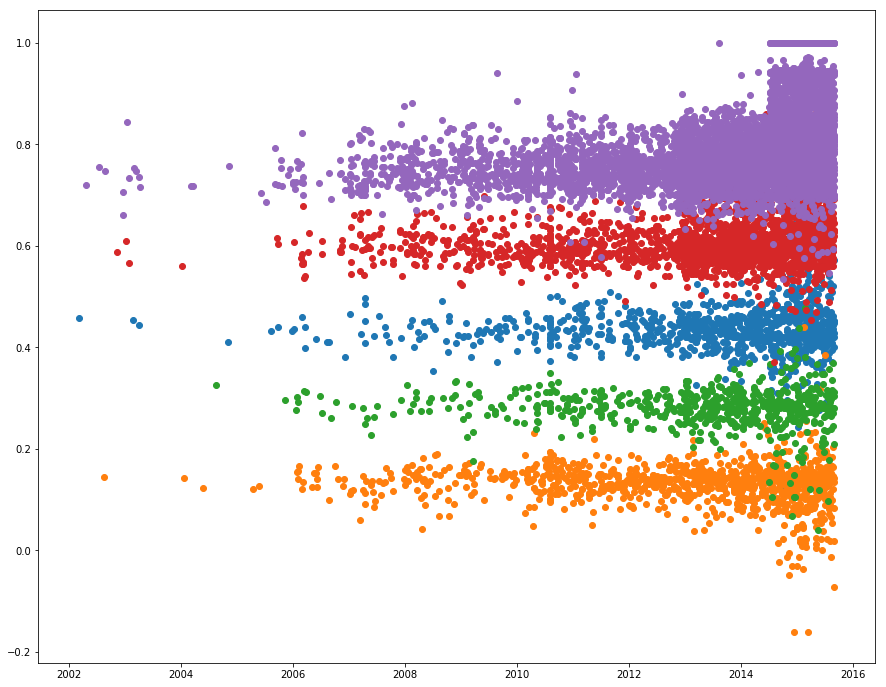

In [87]:
plt.figure(figsize=(15,12))
plt.scatter(p_d.loc[p_d['star_rating']==3,'review_date'],p_d.loc[p_d['star_rating']==3,'sense_score'])
plt.scatter(p_d.loc[p_d['star_rating']==1,'review_date'],p_d.loc[p_d['star_rating']==1,'sense_score'])
plt.scatter(p_d.loc[p_d['star_rating']==2,'review_date'],p_d.loc[p_d['star_rating']==2,'sense_score'])
plt.scatter(p_d.loc[p_d['star_rating']==4,'review_date'],p_d.loc[p_d['star_rating']==4,'sense_score'])
plt.scatter(p_d.loc[p_d['star_rating']==5,'review_date'],p_d.loc[p_d['star_rating']==5,'sense_score'])

In [ ]:
train_set

In [90]:
p_d_ts=p_d.set_index('review_date')

In [150]:
month=p_d_ts[(p_d_ts.index>'2015-01') & (p_d_ts.index<'2015-02')]

(735599.0, 735629.0)

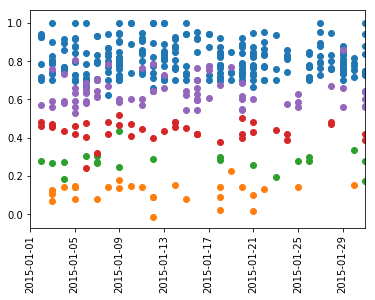

In [117]:
plt.scatter(month.loc[month['star_rating']==5].index,month.loc[month['star_rating']==5,'sense_score'])
plt.scatter(month.loc[month['star_rating']==1].index,month.loc[month['star_rating']==1,'sense_score'])
plt.scatter(month.loc[month['star_rating']==2].index,month.loc[month['star_rating']==2,'sense_score'])
plt.scatter(month.loc[month['star_rating']==3].index,month.loc[month['star_rating']==3,'sense_score'])
plt.scatter(month.loc[month['star_rating']==4].index,month.loc[month['star_rating']==4,'sense_score'])

plt.xticks(rotation=90)
plt.xlim('2015-01-01','2015-01-31')

## 要通过变化趋势，来查看评论对未来的影响
    因素：评论的增减数量

In [151]:
month=month.groupby(['review_date','star_rating']).agg({'star_rating':'count'})
month.rename(columns={'star_rating':'count'},inplace=True)

In [148]:
month.to_csv('test.csv')

In [165]:
# month.loc[('2015-01-02':'2015-01-31',1)]
month.loc[('2015-01-02', 1):('2015-01-31', 1)]
month=month.reset_index()

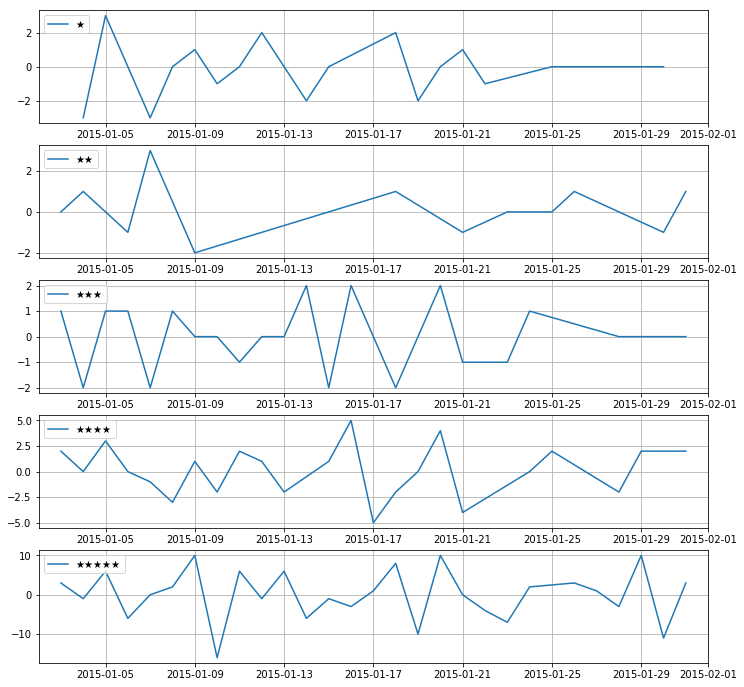

In [208]:
plt.figure(figsize=(12,12))
for i in range(1,6):
    one=month.loc[month['star_rating']==i][['count','review_date']].set_index('review_date')
    plt.subplot(5,1,i)
    plt.plot(one.diff(1),label='★'*i)
    plt.grid()
    plt.xlim('2015-01-02','2015-02-01')
    plt.legend(loc='upper left')

# Problem_e

In [260]:
good=p_c[p_c['sense_score']>0.6]['review_body']
bad=p_c[p_c['sense_score']<0.2]['review_body']
good=data_clean(good)
bad=data_clean(bad)

finish clean
finish clean


In [252]:

res_g=select_tag(['JJ','JJR','JJS','UH'],nltk.pos_tag(word_tokenize(good)))
res_b=select_tag(['JJ','JJR','JJS','UH'],nltk.pos_tag(word_tokenize(bad)))

finish clean
finish clean


In [253]:
good_adj=FreqDist(res_g)
bad_adj=FreqDist(res_b)

(-0.5, 399.5, 199.5, -0.5)

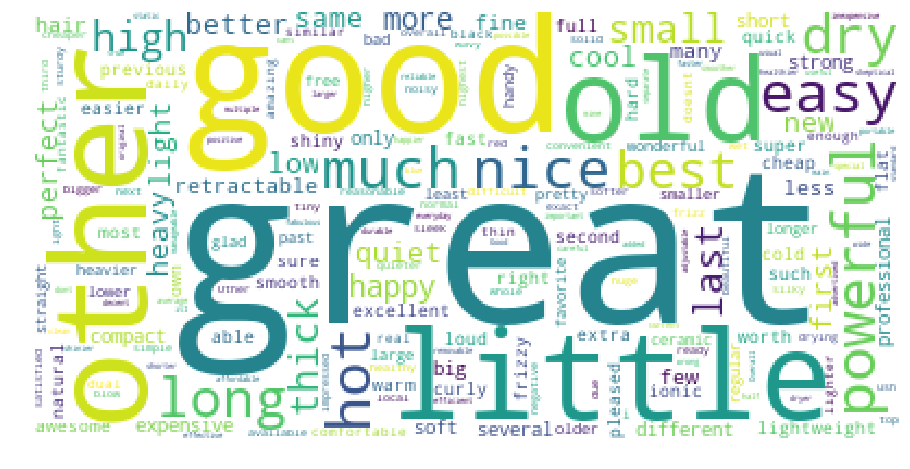

In [254]:
wc=WordCloud(background_color='White')#设置词云背景颜色及形状
wc.generate_from_frequencies(good_adj)#读进词频数据
plt.figure(figsize=(110,8))
#展示图片
plt.imshow(wc)
plt.axis("off")#去除坐标轴

(-0.5, 399.5, 199.5, -0.5)

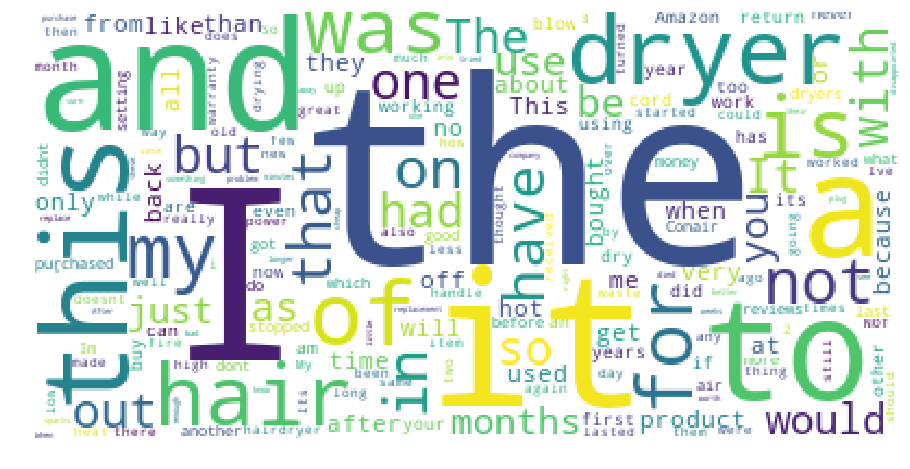

In [261]:
wc=WordCloud(background_color='White')#设置词云背景颜色及形状
wc.generate_from_frequencies(FreqDist(word_tokenize(bad)))#读进词频数据
plt.figure(figsize=(110,8))
#展示图片
plt.imshow(wc)
plt.axis("off")#去除坐标轴